In [ ]:
# Classification of points (images) lying on one side of the curve - the decision boundary:
#
#
#                  (1,3)                (3,3)
#                       o-----------------o
#                      /                   \      class 0
#                     /                     \
#                    /                       \
#                   /                         \
# -----------------o  (-1,1)            (5,1)  o-------------------------------------------
#
#                              class 1

In [ ]:
import time
import os.path
import pdb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
print(tf.__version__)
# if tensorflow2 use tf.compat.v1. apart tf. (see classification2 script)
tf.compat.v1.disable_eager_execution()
num_of_features = 2
num_of_epochs = 1000
num_to_show = 50

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, num_of_features])  # place for input vectors
y_ = tf.placeholder(tf.float32, shape=[None, 1])               # place for desired output of ANN

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


2.18.0


### Analytical version
(See more: https://d2l.ai/chapter_linear-regression/linear-regression.html )

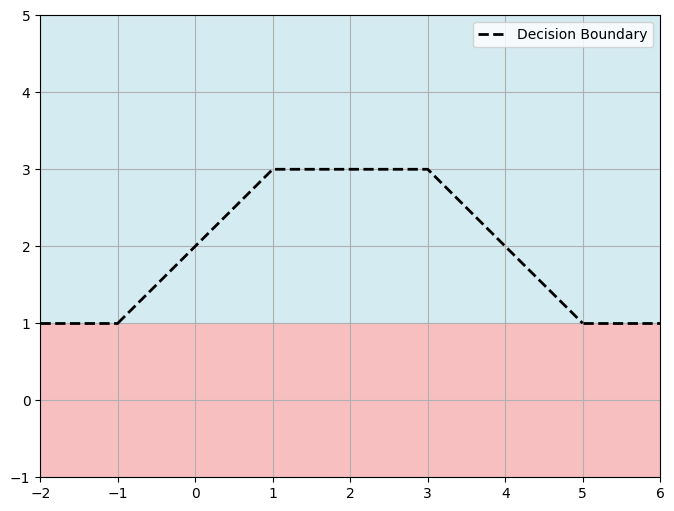

In [95]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

import numpy as np
import matplotlib.pyplot as plt


x = tf.placeholder(tf.float32, shape=[None, 2])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# 1st Layer: 4 boundary neurons (trapezoid)
IW_1 = tf.constant([
    [-1.0,  1.0],   # y > x + 2   → AB side
    [ 0.0, -1.0],   # y < 3       → top
    [ 1.0,  1.0],   # y > -x + 6  → CD side
    [ 0.0,  1.0],   # y > 1       → bottom trapezoid
], dtype=tf.float32)

b1 = tf.constant([-2.0, 3.0, -6.0, -1.0], dtype=tf.float32)

h1 = tf.cast(tf.matmul(x, IW_1, transpose_b=True) + b1 > 0, tf.float32)

# 2nd Layer: 2 neurons (trapezoid and below y=1 logic)
IW_2 = tf.constant([
    [1.0, 1.0, 1.0, 1.0],  # Neuron 1: AND of all trapezoid sides
    [0.0, 0.0, 0.0, 0.0],  # Neuron 2: placeholder for y < 1 (we'll add that manually)
], dtype=tf.float32)

b2 = tf.constant([-3.5, 0.0], dtype=tf.float32)

h2 = tf.matmul(h1, tf.transpose(IW_2)) + b2

# Manually inject neuron for y < 1 detection
strip = tf.cast(tf.matmul(x, tf.constant([[0.0], [-1.0]])) + 1.0 > 0, tf.float32)
h2 = tf.concat([tf.cast(h2[:, 0:1] > 0, tf.float32), strip], axis=1)

# Final layer: OR of the two neurons (trapezoid OR below y=1)
output = tf.reduce_max(h2, axis=1, keepdims=True)
y = tf.sigmoid(10 * (output - 0.5))


sess = tf.Session()
sess.run(tf.global_variables_initializer())

xx, yy = np.meshgrid(np.linspace(-2, 6, 300), np.linspace(-1, 5, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]

zz = sess.run(y, feed_dict={x: grid_points})
zz = zz.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, zz, levels=[-0.1, 0.5, 1.1], colors=['lightblue', 'lightcoral'], alpha=0.5)

plt.plot([-2, -1], [1, 1], 'k--', lw=2)
plt.plot([5, 6], [1, 1], 'k--', lw=2)

trapezoid_edges = np.array([
    [-1, 1], [1, 3], [3, 3], [5, 1]
])
plt.plot(trapezoid_edges[:, 0], trapezoid_edges[:, 1], 'k--', lw=2, label='Decision Boundary')

plt.legend()
plt.grid(True)
plt.show()


FailedPreconditionError: Graph execution error:

Detected at node 'add_48/ReadVariableOp' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
    File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
    File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    File "<ipython-input-113-061370b44b99>", line 44, in <cell line: 0>
Node: 'add_48/ReadVariableOp'
Could not find variable Variable_71. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Container localhost does not exist. (Could not find resource: localhost/Variable_71)
	 [[{{node add_48/ReadVariableOp}}]]

Original stack trace for 'add_48/ReadVariableOp':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
  File "<ipython-input-113-061370b44b99>", line 44, in <cell line: 0>
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/override_binary_operator.py", line 113, in binary_op_wrapper
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/tensor_math_operator_overrides.py", line 28, in _add_dispatch_factory
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/math_ops.py", line 1713, in _add_dispatch
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 732, in convert_to_tensor
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 217, in convert
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 2375, in _dense_var_to_tensor
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 1621, in _dense_var_to_tensor
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 656, in value
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 841, in _read_variable_op
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 831, in read_and_set_handle
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 548, in read_variable_op
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 2701, in _create_op_internal
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 1196, in from_node_def


### Trainable version

Step 0, Cross-Entropy Loss: 0.7228
Step 50, Cross-Entropy Loss: 0.6737
Step 100, Cross-Entropy Loss: 0.6432
Step 150, Cross-Entropy Loss: 0.6039
Step 200, Cross-Entropy Loss: 0.5182
Step 250, Cross-Entropy Loss: 0.3956
Step 300, Cross-Entropy Loss: 0.2919
Step 350, Cross-Entropy Loss: 0.2186
Step 400, Cross-Entropy Loss: 0.1664
Step 450, Cross-Entropy Loss: 0.1285
Step 500, Cross-Entropy Loss: 0.1007
Step 550, Cross-Entropy Loss: 0.0798
Step 600, Cross-Entropy Loss: 0.0638
Step 650, Cross-Entropy Loss: 0.0516
Step 700, Cross-Entropy Loss: 0.0421
Step 750, Cross-Entropy Loss: 0.0346
Step 800, Cross-Entropy Loss: 0.0287
Step 850, Cross-Entropy Loss: 0.0240
Step 900, Cross-Entropy Loss: 0.0203
Step 950, Cross-Entropy Loss: 0.0173


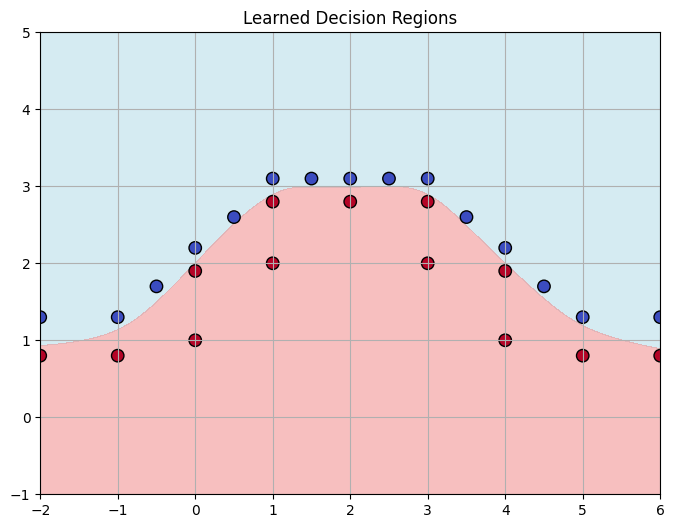

In [ ]:
# First hidden layer (5 neurons)
IW1 = tf.Variable(tf.random.normal([5, 2], stddev=1.0))
b1 = tf.Variable(tf.zeros([5]))
h1 = tf.sigmoid(tf.matmul(x, tf.transpose(IW1)) + b1)

# Second hidden layer (3 neurons)
IW2 = tf.Variable(tf.random.normal([3, 5], stddev=1.0))
b2 = tf.Variable(tf.zeros([3]))
h2 = tf.sigmoid(tf.matmul(h1, tf.transpose(IW2)) + b2)

# Output layer (1 neuron)
LW = tf.Variable(tf.random.normal([3, 1], stddev=1.0))
b3 = tf.Variable(tf.zeros([1]))
y = tf.sigmoid(tf.matmul(h2, LW) + b3)

# Loss: Binary cross-entropy
cross_entropy = tf.reduce_mean(-y_ * tf.log(y + 1e-6) - (1 - y_) * tf.log(1 - y + 1e-6))

# Optimizer: Adam
train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cross_entropy)

# Initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Training data
train_points = np.array([
    [-2,   0.8], [-1,  0.8], [0,     1], [1,     2], [1.5, 3.1], [3,   2], [4,    1], [5,  0.8], [6,  0.8],
    [-2,   1.3], [-1,  1.3], [0,   2.2], [1,   3.1], [2,   3.1], [3, 3.1], [4,  2.2], [5 , 1.3], [6 , 1.3],
    [0,    1.9], [1,   2.8], [2,   2.8], [3,   2.8], [4,   1.9],
    [-0.5, 1.7], [0.5, 2.6], [2.5, 3.1], [3.5, 2.6], [4.5, 1.7],
], dtype=np.float32)

train_labels = np.array([
    [1], [1], [1], [1], [0], [1], [1], [1], [1],
    [0], [0], [0], [0], [0], [0], [0], [0], [0],
    [1], [1], [1], [1], [1],
    [0], [0], [0], [0], [0],
], dtype=np.float32)

# Training loop
for step in range(1000):
    sess.run(train_step, feed_dict={x: train_points, y_: train_labels})
    if step % 50 == 0:
        loss_val = sess.run(cross_entropy, feed_dict={x: train_points, y_: train_labels})
        print(f"Step {step}, Cross-Entropy Loss: {loss_val:.4f}")

# Visualize decision boundary
xx, yy = np.meshgrid(np.linspace(-2, 6, 300), np.linspace(-1, 5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = sess.run(y, feed_dict={x: grid})
zz = zz.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, zz, levels=[-0.1, 0.5, 1.1], colors=['lightblue', 'lightcoral'], alpha=0.5)
plt.scatter(train_points[:, 0], train_points[:, 1], c=np.squeeze(train_labels), cmap='coolwarm', edgecolor='k', s=80)
plt.title("Learned Decision Regions")
plt.grid(True)
plt.show()

#### The training process

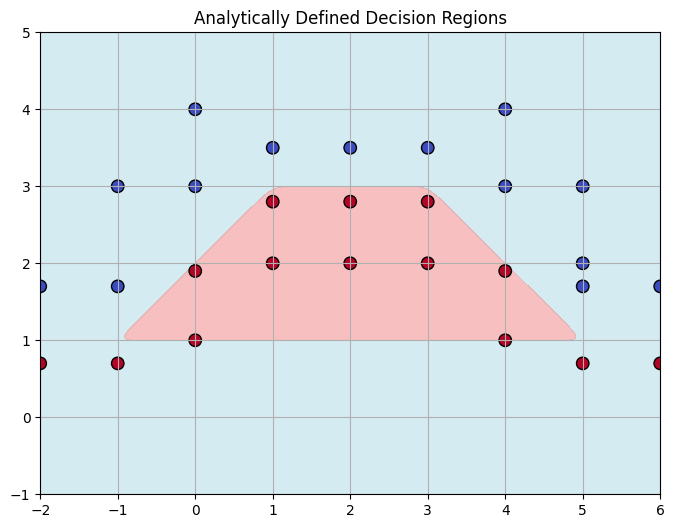

In [79]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

# Placeholder for 2D input points
x = tf.placeholder(tf.float32, [None, 2])  # shape: [batch_size, 2]

# Handcrafted weights and biases for trapezoid logic
# We'll define neurons that approximate the following conditions using sigmoid units

# Neuron 1: y >= 1  → sigmoid(k*(y - 1))
# Neuron 2: y <= x + 2 → sigmoid(k*(x + 2 - y))
# Neuron 3: y <= -x + 6 → sigmoid(k*(-x + 6 - y))
# Neuron 4: y <= 3 → sigmoid(k*(3 - y))

k = 20.0  # sigmoid steepness

# Input weight matrix [4 neurons × 2 inputs]
# Each row is [wx, wy] for one neuron
IW = tf.constant([
    [0.0, k],         # Neuron 1: y ≥ 1 → sigmoid(k*y - k)
    [k, -k],          # Neuron 2: y ≤ x + 2 → sigmoid(k*x - k*y + 2k)
    [-k, -k],         # Neuron 3: y ≤ -x + 6 → sigmoid(-k*x - k*y + 6k)
    [0.0, -k],        # Neuron 4: y ≤ 3 → sigmoid(-k*y + 3k)
], dtype=tf.float32)

# Biases for those neurons
b = tf.constant([
    -k * 1,      # Neuron 1: y - 1
    k * 2,       # Neuron 2: x + 2 - y
    k * 6,       # Neuron 3: -x + 6 - y
    k * 3,       # Neuron 4: 3 - y
], dtype=tf.float32)

# First layer: logic neurons
h = tf.sigmoid(tf.matmul(x, tf.transpose(IW)) + b)  # shape [batch_size, 4]

# Output layer: approximates logical AND by multiplying all 4 outputs
# Soft product using log-space addition
log_h = tf.log(h + 1e-6)
sum_log_h = tf.reduce_sum(log_h, axis=1, keepdims=True)
y = tf.exp(sum_log_h)  # equivalent to product of h1 * h2 * h3 * h4

# Clamp output between 0 and 1
y = tf.minimum(tf.maximum(y, 1e-6), 1 - 1e-6)

# Visualization
xx, yy = np.meshgrid(np.linspace(-2, 6, 300), np.linspace(-1, 5, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
with tf.Session() as sess:
    zz = sess.run(y, feed_dict={x: grid})
zz = zz.reshape(xx.shape)


plt.figure(figsize=(8,6))
plt.contourf(xx, yy, zz, levels=[-0.1, 0.5, 1.1], colors=['lightblue', 'lightcoral'], alpha=0.5)
plt.scatter(train_points[:, 0], train_points[:, 1], c=np.squeeze(train_labels), cmap='coolwarm', edgecolor='k', s=80)
plt.title("Analytically Defined Decision Regions")
plt.grid(True)
plt.show()


#### Drawing decision boundary

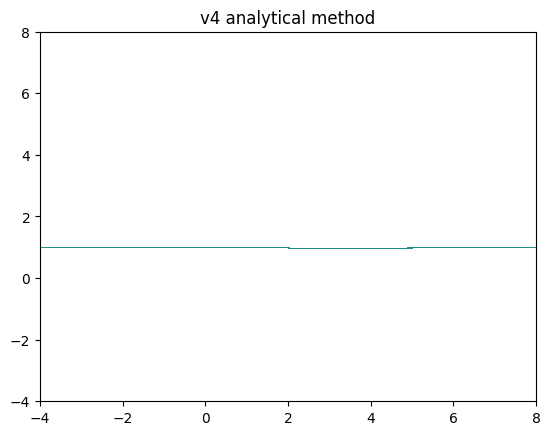

In [ ]:
X1, X2 = np.meshgrid(np.linspace(-4, 8, 120), np.linspace(-4,8, 120))  # grid of points in 2D plane
P = np.stack((X1.flatten(),X2.flatten()), axis=1)                    # points formated for ANN input
Y = sess.run(y_a, feed_dict={x: P})                                    # ANN outputs for flatten grid  points
Z = np.reshape(Y,X1.shape)                                           # reshaping to shape of grid
plt.contourf(X1, X2, Z, levels=[0.5, 1.0])                           # curve for level=0.5 - a decision boundary, shaded class 1 area
plt.title('v4 analytical method')
plt.show()


#### Drawing 3D mesh

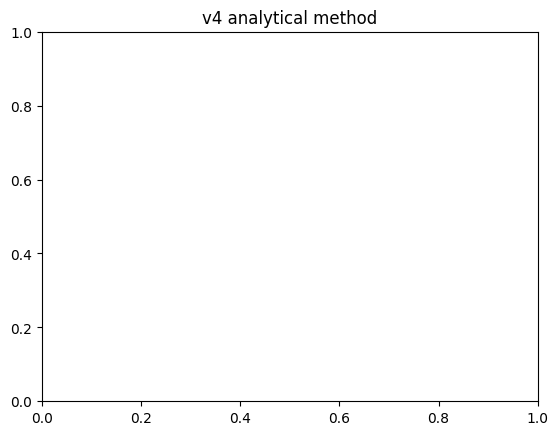

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X1, X2, Z, rstride=1, cstride=1, cmap=cm.viridis)
plt.title('v4 analytical method')
plt.show()